# Re-run the dimension reduction analysis with linear models

In [978]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import analysis_pca
import pickle
from cbmanifold.linear_model import LinearModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [979]:
# load ../../models/linear_model_FN_PV_dim_reduced_20250529.pkl
with open('../../models/linear_model_FN_PV_dim_reduced_20250529.pkl', 'rb') as f:
    lmrs = pickle.load(f)

with open('../../models/model_av_from_pv_20250529.pkl', 'rb') as f:
    model_av = pickle.load(f)

# Create a matrix by vertically stacking all rate matrices from the linear models
rate_matrix = np.vstack([lm.p for lm in lmrs])
drate_matrix = np.vstack([lm.dp for lm in lmrs])
lmrs[2].params0

array([0.47885947])

In [980]:
lm_all_angles = LinearModel(
    rate=rate_matrix,
    drate=drate_matrix,
    label='fnn_all_angles',
    params0 = lmrs[0].params0
)
lm_all_angles.n_params = 1


Dimensions: 1, Variance explained: 63.44255788713461
Dimensions: 2, Variance explained: 80.15800625704462
Dimensions: 3, Variance explained: 88.69154148482441
Dimensions: 4, Variance explained: 92.99160462579597
Dimensions: 5, Variance explained: 96.01736964881516
Dimensions to be reduced: 3


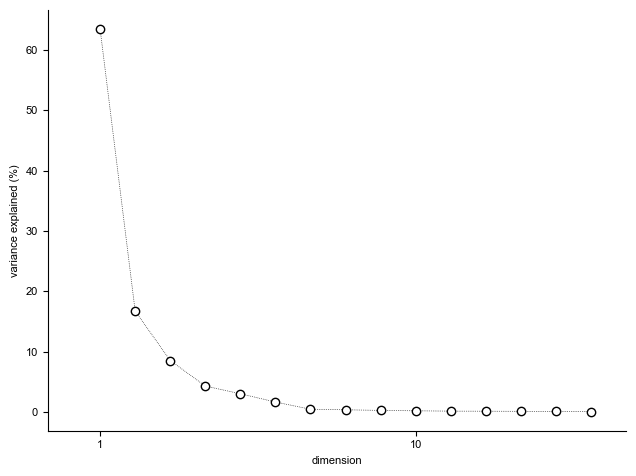

In [981]:
import cbmanifold as cbm
from cbmanifold.decomposition import pmPCA

dd, p, v = pmPCA(rate_matrix)
var_explained = dd/np.sum(dd)*1e2;
var_explained_cumsum = np.cumsum(var_explained);
for i in range(5):
    print(f'Dimensions: {i+1}, Variance explained: {var_explained_cumsum[i]}')

nmode = np.where(var_explained_cumsum > 87.5)[0][0]+1
print(f'Dimensions to be reduced: {nmode}')

fig, ax = plt.subplots()
_ = cbm.plot.plot_var_explained(var_explained, ax=ax)


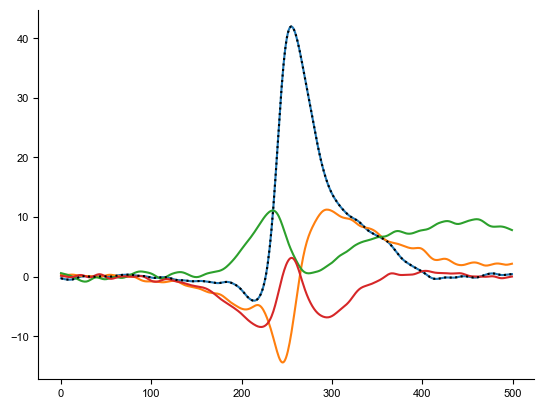

In [982]:
v[:, 1] = -v[:, 1]
p[:, 1] = -p[:, 1]
v[:, 2] = -v[:, 2]
p[:, 2] = -p[:, 2]
v[:, 3] = -v[:, 3]
p[:, 3] = -p[:, 3]

plt.plot((v[:,:4].T @ rate_matrix).T)
plt.plot(p[:,0], ':k')

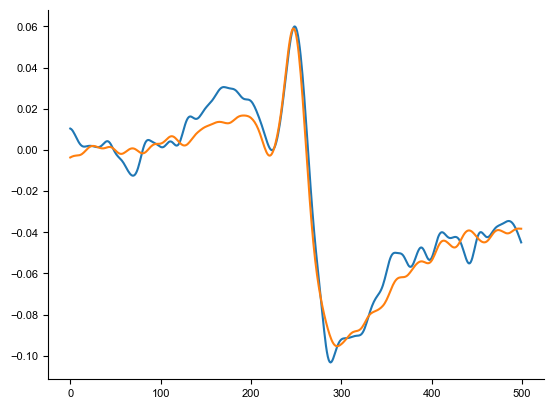

In [983]:
Wpca = v[:,:4]
rbar = Wpca @ p[:,:4].T

n = 19
plt.plot(rate_matrix[n]/np.linalg.norm(rate_matrix[n]))
plt.plot(rbar[n]/np.linalg.norm(rbar[n]))

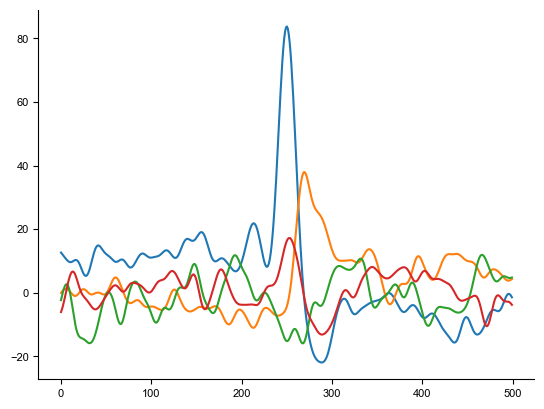

In [984]:
pp = p[:,:4].T
dpp = Wpca.T @ drate_matrix
plt.plot(dpp.T)

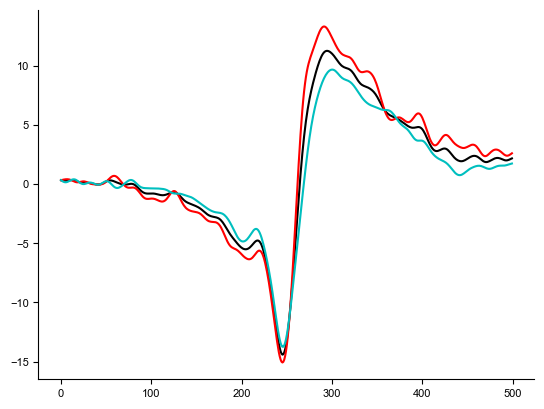

In [985]:
n = 1
plt.plot(pp[n,:], 'k')
plt.plot(pp[n,:] + 0.1*dpp[n,:], 'r')
plt.plot(pp[n,:] - 0.1*dpp[n,:], 'c')


In [986]:
# sample three colors from YIGn colormap
n_steps = 7
cols = plt.cm.Greens(np.linspace(0.3, 0.8, n_steps))
prange = np.linspace(300, 660, n_steps)-478.85947
prange = prange*1e-3

def predict_av_from_pv(pv, model):
    """
    Predict AV given PV based on the linear relationship.

    Parameters:
    - pv: Peak velocity value(s) to predict for
    - model

    Returns:
    - av_predicted: Predicted average velocity value(s)
    """
    av_predicted = model.coef_[0] * pv + model.intercept_
    return av_predicted

def dur_from_pv(pv, model):
    return 10/predict_av_from_pv(pv, model)

def dur_from_pv(pv, model):
    return 10/predict_av_from_pv(pv, model)

pv0 = 0.47885947
durs = dur_from_pv(pv0+prange, model_av).astype(int)

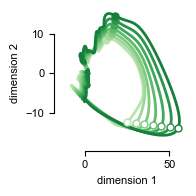

In [987]:
_, ax = plt.subplots(figsize=(2, 2))

dim1 = 0
dim2 = 1

for i in range(n_steps):

    ax.plot(pp[dim1,:] + prange[i]*dpp[dim1,:], pp[dim2,:] + prange[i]*dpp[dim2,:], c=cols[i], linewidth=2, zorder=1)

for i in range(n_steps):
    ax.plot(pp[dim1,250] + prange[i]*dpp[dim1,250],
            pp[dim2,250] + prange[i]*dpp[dim2,250],
           'o', markersize=5, markerfacecolor='w', color=cols[i], zorder=3)

#     ax.scatter(lmr.p[0,220] + prange[i]*lmr.dp[0,220],
#                lmr.p[1,220] + prange[i]*lmr.dp[1,220],
#                25, c=cols[i], zorder=1)

    ax.plot(pp[dim1,250+durs[i]] + prange[i]*dpp[dim1,250+durs[i]],
            pp[dim2,250+durs[i]] + prange[i]*dpp[dim2,250+durs[i]],
           'o', markersize=5, markerfacecolor=cols[i], color=cols[i], zorder=2)

    # ax.scatter(pp[dim1,220] + prange[i]*dpp[dim1,220], pp[dim2,220] + prange[i]*dpp[dim2,220], 50, c=cols[i], zorder=2)

plt.xlabel(f'dimension {dim1+1}')
plt.ylabel(f'dimension {dim2+1}')
ax.set_ylim(-16, 16)
ax.set_xlim(-10, 60)

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['bottom'].set_bounds(0, 50)
ax.spines['left'].set_bounds(-10, 10)

ax.set(
    xticks=[0, 50],
    yticks=[-10, 0, 10],
)

plt.tight_layout()
plt.savefig('dim_reduction_linear_models_angle.pdf', dpi=300)


In [988]:
sigpv = 0.09520212*0
from sklearn.linear_model import LinearRegression

for ori in range(8):
    for n in range(4):
        yy = np.hstack((lmrs[ori].p[n,:], sigpv*lmrs[0].dp[n,:]))
        xx = np.hstack((pp, sigpv*dpp)).T
        model = LinearRegression().fit(xx, yy)
        print('ori =', ori, 'n =', n, 'R^2 =', model.score(xx, yy))
    print('')


ori = 0 n = 0 R^2 = 0.9911697926485178
ori = 0 n = 1 R^2 = 0.9688461232034454
ori = 0 n = 2 R^2 = 0.922408325698943
ori = 0 n = 3 R^2 = 0.8589426160382091

ori = 1 n = 0 R^2 = 0.9966858606985792
ori = 1 n = 1 R^2 = 0.9752562050379995
ori = 1 n = 2 R^2 = 0.8738335107236344
ori = 1 n = 3 R^2 = 0.525880689604638

ori = 2 n = 0 R^2 = 0.9913169883647521
ori = 2 n = 1 R^2 = 0.9868565255180493
ori = 2 n = 2 R^2 = 0.9190523956710938
ori = 2 n = 3 R^2 = 0.7090325957507736

ori = 3 n = 0 R^2 = 0.9929445166062753
ori = 3 n = 1 R^2 = 0.9723032717773434
ori = 3 n = 2 R^2 = 0.9586541983406409
ori = 3 n = 3 R^2 = 0.8084979498760018

ori = 4 n = 0 R^2 = 0.9961436985824331
ori = 4 n = 1 R^2 = 0.977811424684338
ori = 4 n = 2 R^2 = 0.9535937566851014
ori = 4 n = 3 R^2 = 0.884560985214312

ori = 5 n = 0 R^2 = 0.989709532250579
ori = 5 n = 1 R^2 = 0.9477150661844341
ori = 5 n = 2 R^2 = 0.9780770917875042
ori = 5 n = 3 R^2 = 0.9495013769215906

ori = 6 n = 0 R^2 = 0.9955158977879486
ori = 6 n = 1 R^2 = 0.97

In [989]:
lmL = cbm.decomposition.reduce_dimensionality(lm_all_angles, 4)
lmL = cbm.utils.flip_sign(lmL, [1, 2]) # flip signs to make the cycles go CCW



In [990]:

sigpv = 0.09520212*0
from sklearn.linear_model import LinearRegression

ncfs = []
for ori in range(8):
    cfs = []
    for n in range(4):
        yy = np.hstack((lmrs[ori].p[n,:], sigpv*lmrs[ori].dp[n,:]))
        xx = np.hstack((lmL.p, sigpv*lmL.dp)).T
        model = LinearRegression().fit(xx, yy)
        print('ori =', ori, 'n =', n, 'R^2 =', model.score(xx, yy))
        cfs.append(model.coef_)
    print('')
    cfs = np.array(cfs)
    ncfs.append(np.linalg.norm(cfs))

nn = np.sqrt(np.mean(ncfs))
print(nn)

lmL.p = lmL.p*nn
lmL.dp = lmL.dp*nn

ori = 0 n = 0 R^2 = 0.9911697926485178
ori = 0 n = 1 R^2 = 0.9688461232034453
ori = 0 n = 2 R^2 = 0.922408325698943
ori = 0 n = 3 R^2 = 0.8589426160382091

ori = 1 n = 0 R^2 = 0.9966858606985792
ori = 1 n = 1 R^2 = 0.9752562050379995
ori = 1 n = 2 R^2 = 0.8738335107236345
ori = 1 n = 3 R^2 = 0.5258806896046381

ori = 2 n = 0 R^2 = 0.9913169883647521
ori = 2 n = 1 R^2 = 0.9868565255180493
ori = 2 n = 2 R^2 = 0.9190523956710938
ori = 2 n = 3 R^2 = 0.7090325957507736

ori = 3 n = 0 R^2 = 0.9929445166062753
ori = 3 n = 1 R^2 = 0.9723032717773434
ori = 3 n = 2 R^2 = 0.9586541983406409
ori = 3 n = 3 R^2 = 0.8084979498760018

ori = 4 n = 0 R^2 = 0.9961436985824331
ori = 4 n = 1 R^2 = 0.977811424684338
ori = 4 n = 2 R^2 = 0.9535937566851014
ori = 4 n = 3 R^2 = 0.884560985214312

ori = 5 n = 0 R^2 = 0.989709532250579
ori = 5 n = 1 R^2 = 0.9477150661844341
ori = 5 n = 2 R^2 = 0.9780770917875042
ori = 5 n = 3 R^2 = 0.9495013769215906

ori = 6 n = 0 R^2 = 0.9955158977879486
ori = 6 n = 1 R^2 = 0.9

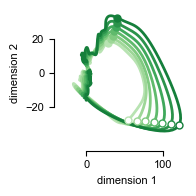

In [991]:

fig, ax = plt.subplots(figsize=(2, 2))

dim1 = 0
dim2 = 1

for i in range(n_steps):

    ax.plot(lmL.p[dim1,:] + prange[i]*lmL.dp[dim1,:], lmL.p[dim2,:] + prange[i]*lmL.dp[dim2,:], c=cols[i], linewidth=2, zorder=1)

for i in range(n_steps):
    ax.plot(lmL.p[dim1,250] + prange[i]*lmL.dp[dim1,250],
            lmL.p[dim2,250] + prange[i]*lmL.dp[dim2,250],
           'o', markersize=5, markerfacecolor='w', color=cols[i], zorder=3)

#     ax.scatter(lmr.p[0,220] + prange[i]*lmr.dp[0,220],
#                lmr.p[1,220] + prange[i]*lmr.dp[1,220],
#                25, c=cols[i], zorder=1)

    ax.plot(lmL.p[dim1,250+durs[i]] + prange[i]*lmL.dp[dim1,250+durs[i]],
            lmL.p[dim2,250+durs[i]] + prange[i]*lmL.dp[dim2,250+durs[i]],
           'o', markersize=5, markerfacecolor=cols[i], color=cols[i], zorder=2)

    # ax.scatter(pp[dim1,220] + prange[i]*dpp[dim1,220], pp[dim2,220] + prange[i]*dpp[dim2,220], 50, c=cols[i], zorder=2)

plt.xlabel(f'dimension {dim1+1}')
plt.ylabel(f'dimension {dim2+1}')

ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.spines['bottom'].set_bounds(0, 100)
ax.spines['left'].set_bounds(-20, 20)

ax.set(
    xticks=[0, 100],
    yticks=[-20, 0, 20],
)
plt.tight_layout()
plt.savefig('dim_reduction_linear_models_angle.pdf', dpi=300)


ori = 3 n = 0 R^2 = 0.9929445166062753
1.1017748680152935
ori = 3 n = 1 R^2 = 0.9723032717773434
1.168759582764017
ori = 3 n = 2 R^2 = 0.9586541983406409
1.067261834648543
ori = 3 n = 3 R^2 = 0.8084979498760017
0.9816117539379594


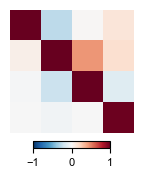

In [992]:
ori = 3
cfs = []

for n in range(4):
    yy = np.hstack((lmrs[ori].p[n,:], sigpv*lmrs[ori].dp[n,:]))
    xx = np.hstack((lmL.p, sigpv*lmL.dp)).T
    model = LinearRegression().fit(xx, yy)
    print('ori =', ori, 'n =', n, 'R^2 =', model.score(xx, yy))
    print(np.linalg.norm(model.coef_))
    cfs.append(model.coef_)

cfs = np.array(cfs)

fig, ax = plt.subplots(figsize=(2, 2))
ms = ax.matshow(-cfs, cmap='RdBu_r', vmin=-1, vmax=1)

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
cb = plt.colorbar(ms, shrink=0.5, ax=ax, aspect=10, orientation='horizontal', pad=0.05)


plt.savefig('dim_reduction_linear_models_angle_cfs.pdf', dpi=300)


In [993]:
sigpv = 0.09520212*0
from sklearn.linear_model import LinearRegression

scores = []
for ori in range(8):
    score1 = []
    for n in range(4):
        yy = np.hstack((lmrs[ori].p[n,:], sigpv*lmrs[0].dp[n,:]))
        xx = np.hstack((pp, sigpv*dpp)).T
        model = LinearRegression().fit(xx, yy)
        print('ori =', ori, 'n =', n, 'R^2 =', model.score(xx, yy))
        score1.append(model.score(xx, yy))
    print('')
    scores.append(np.array(score1))


ori = 0 n = 0 R^2 = 0.9911697926485178
ori = 0 n = 1 R^2 = 0.9688461232034454
ori = 0 n = 2 R^2 = 0.922408325698943
ori = 0 n = 3 R^2 = 0.8589426160382091

ori = 1 n = 0 R^2 = 0.9966858606985792
ori = 1 n = 1 R^2 = 0.9752562050379995
ori = 1 n = 2 R^2 = 0.8738335107236344
ori = 1 n = 3 R^2 = 0.525880689604638

ori = 2 n = 0 R^2 = 0.9913169883647521
ori = 2 n = 1 R^2 = 0.9868565255180493
ori = 2 n = 2 R^2 = 0.9190523956710938
ori = 2 n = 3 R^2 = 0.7090325957507736

ori = 3 n = 0 R^2 = 0.9929445166062753
ori = 3 n = 1 R^2 = 0.9723032717773434
ori = 3 n = 2 R^2 = 0.9586541983406409
ori = 3 n = 3 R^2 = 0.8084979498760018

ori = 4 n = 0 R^2 = 0.9961436985824331
ori = 4 n = 1 R^2 = 0.977811424684338
ori = 4 n = 2 R^2 = 0.9535937566851014
ori = 4 n = 3 R^2 = 0.884560985214312

ori = 5 n = 0 R^2 = 0.989709532250579
ori = 5 n = 1 R^2 = 0.9477150661844341
ori = 5 n = 2 R^2 = 0.9780770917875042
ori = 5 n = 3 R^2 = 0.9495013769215906

ori = 6 n = 0 R^2 = 0.9955158977879486
ori = 6 n = 1 R^2 = 0.97

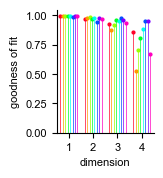

In [994]:
import matplotlib

cmap = matplotlib.colormaps.get_cmap("gist_rainbow")
C_list = cmap( np.linspace(0.0, 1.0, 8) ) # extract 20 colors from cmap

x = np.arange(1,5,1)
fig, ax = plt.subplots(figsize=(1.25, 1.6))

width = 0.1
b = 7
for a in range(8):
    ax.plot(x - width * b + 0.35, scores[a], 'o', color = C_list[a], markersize=2)
    for k in x:
        ax.plot([k - width * b + 0.35, k - width * b + 0.35], [0, scores[a][k-1]], '-', color = C_list[a], linewidth=0.5)
    b = b - 1
# ax.plot([0, 5], [85, 85], ':k')

ax.set_xticks(x)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(0, 1.05)
ax.set_xlabel('dimension')
ax.set_ylabel('goodness of fit')

plt.savefig('dim_reduction_linear_models_angle_scores.pdf',  bbox_inches='tight', dpi=600)


## Check if the rate matrix can be further reduced down.


## Onset delay

In [995]:

# here load rate_cat using numpy.load with allow_pickle=True

from scipy.ndimage import gaussian_filter1d

path_data = '../../data/processed'
date_data = '20250529'
spike_cat = np.load(f'{path_data}/spike_cat_{date_data}.npz', allow_pickle=True)['spike_cat']
vel_cat = np.load(f'{path_data}/vel_cat_{date_data}.npz', allow_pickle=True)['vel_cat']
dur_cat = np.load(f'{path_data}/dur_cat_{date_data}.npz', allow_pickle=True)['dur_cat']

rate_cat = []
for spike1 in spike_cat:
    rate1 = []
    for spike1_per_angle in spike1:
        # filter spike1_per_angle with gaussian_filter1d
        rate2 = 1e3*gaussian_filter1d(spike1_per_angle.astype(float), sigma=6, axis=1)
        rate1.append(rate2[:,50:-50])
    rate_cat.append(rate1)

[ -3.   4.   2.  -5. -13. -22. -19. -13.]


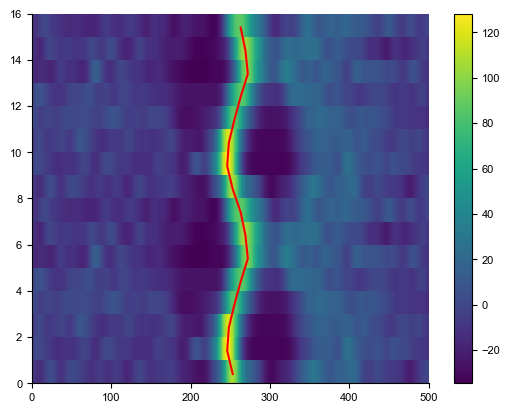

In [996]:
def compute_delay(mean_rate_cat, n):
    delays = np.empty(8)
    # max_swing = (mean_rate_cat[n, :, :]).max(axis=-1)
    # i = np.argmax(max_swing)
    for ori in range(8):
        # xc = np.correlate(mean_rate_cat[n,i,:], mean_rate_cat[n,ori,:], 'same')
        xc = np.correlate(mean_rate_cat[n,:4,:].mean(axis=0), mean_rate_cat[n,ori,:], 'same')
        delays[ori] = xc.argmax() - 250
        if np.abs(delays[ori]) > 200:
            xc = np.correlate(mean_rate_cat[n,:,:].mean(axis=0), mean_rate_cat[n,ori,:], 'same')
            delays[ori] = xc.argmax() - 250
        iinval, = np.where(np.abs(delays)>200)
        delays[iinval] = 20
        # delays[iinval] = delays[iinval-1]

    return delays


mean_rate_cat = np.empty((len(rate_cat), 8, 500))
for i in range(len(rate_cat)):
    for ori in range(8):
        mean_rate_cat[i, ori, :] = rate_cat[i][ori].mean(axis=0)
        mean_rate_cat[i, ori, :] = mean_rate_cat[i, ori, :] - mean_rate_cat[i, ori, :].mean(axis=-1)

n = 10
plt.pcolormesh(np.vstack((
    mean_rate_cat[n, :, :],
    mean_rate_cat[n, :, :])))

z = compute_delay(mean_rate_cat, n)
print(z)
plt.plot(-np.hstack((z,z))+250, np.arange(16)+0.4, 'r')
plt.colorbar()




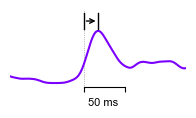

In [997]:
cmap = matplotlib.colormaps.get_cmap("gist_rainbow")
C_list = cmap( np.linspace(0.0, 1.0, 8) ) # extract 20 colors from cmap

tt = np.arange(-250, 250)

fig, ax = plt.subplots(figsize=(2, 1.25  ))
ax.axvline(x=0, ymin=0, ymax=1, linestyle=':', color='black', alpha=0.5, linewidth=0.5)
# ax.plot(tt, mean_rate_cat[n,1,:], color=C_list[1])
ax.plot(tt, mean_rate_cat[n,6,:], color=C_list[6])

ax.spines['bottom'].set_bounds(0, 50)  # Only draw y-axis line from 50 to 150
ax.set_xticks([0, 50])
ax.set_xlim([-90, 125])
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticklabels(['', ''])
ax.set_xlabel('50 ms')
ax.xaxis.set_label_coords(0.53, -0.15)

ipeak1 = np.argmax(mean_rate_cat[n,1,:])
ipeak1 = 250
ipeak6 = np.argmax(mean_rate_cat[n,6,:])
ax.plot([tt[ipeak1], tt[ipeak1]], [110, 150], color='black', linestyle='-', linewidth=1)
ax.plot([tt[ipeak6], tt[ipeak6]], [110, 150], color='black', linestyle='-', linewidth=1)

# horizontal arrow from tt[ipeak1] to tt[ipeak6] at y=140
ax.annotate('', xy=(tt[ipeak1], 130), xytext=(tt[ipeak6], 130),
            arrowprops=dict(arrowstyle='<-', color='black', linewidth=1))

plt.tight_layout()
plt.savefig('illust_latency.pdf')

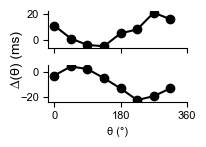

In [998]:
theta = np.arange(0, 370, 45)
delta0 = compute_delay(mean_rate_cat, 0)
delta = compute_delay(mean_rate_cat, 10)

fig, axes = plt.subplots(figsize=(2, 1.5), nrows=2, sharex=True)
axes[0].plot(theta[:-1], delta0, 'ko-')
axes[1].plot(theta[:-1], delta, 'ko-')
axes[0].set_xticks(theta[::4])
# axes[0].set_title('cell 0')
# axes[1].set_title('cell 10')
fig.text(0.01, 0.6, '∆(θ) (ms)', va='center', rotation='vertical', fontsize=10)
axes[1].set_xlabel('θ (°)')

plt.tight_layout()
plt.savefig('latency_0+10.pdf')


In [999]:
from tqdm import trange

delays_all = []
for n in trange(np.shape(mean_rate_cat)[0]):
    delays = compute_delay(mean_rate_cat, n)
    delays_all.append(delays)

delays_all = np.array(delays_all)


100%|██████████| 67/67 [00:00<00:00, 3218.66it/s]


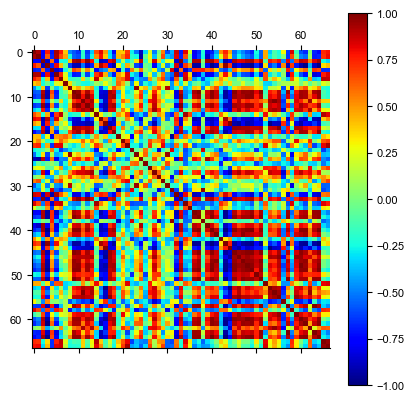

In [1000]:
cc = np.corrcoef(delays_all)
plt.matshow(cc, vmin=-1, vmax=1, cmap='jet')
plt.colorbar()

/opt/miniforge3/envs/cbmanifold/lib/python3.11/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


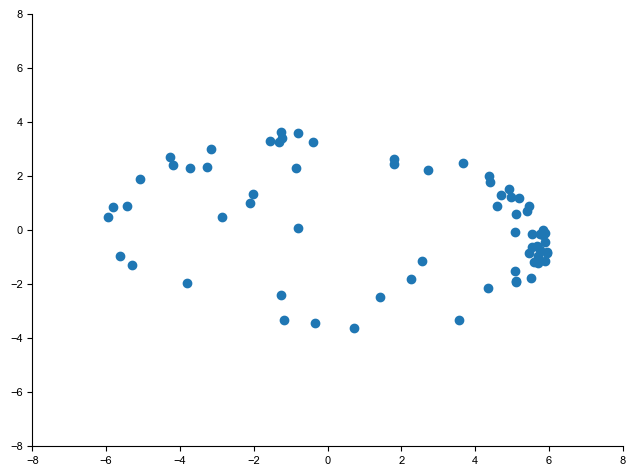

In [1001]:
from sklearn.manifold import MDS
embedding = MDS(dissimilarity='euclidean', random_state = 100)
p_t = embedding.fit_transform(cc)
p_t[:,0] = -p_t[:,0] + (p_t[:,0].max() + p_t[:,0].min())/2
p_t[:,1] = -p_t[:,1] + (p_t[:,1].max() + p_t[:,1].min())/2
plt.plot(p_t[:,0], p_t[:,1], 'o')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.tight_layout()
plt.savefig('MDS_cc.pdf')

(-8.0, 8.0)

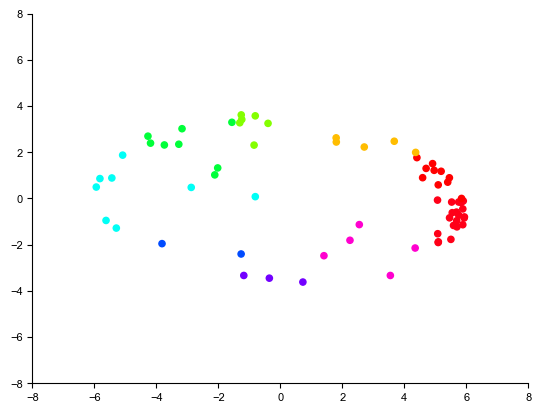

In [1011]:
degs = np.arctan2(p_t[:,1],p_t[:,0])*180/np.pi
qdegs = (np.mod(degs, 360)/45+0.5).astype(int)
plt.scatter(p_t[:,0], p_t[:,1], 20, qdegs, cmap='hsv')
plt.xlim(-8, 8)
plt.ylim(-8, 8)


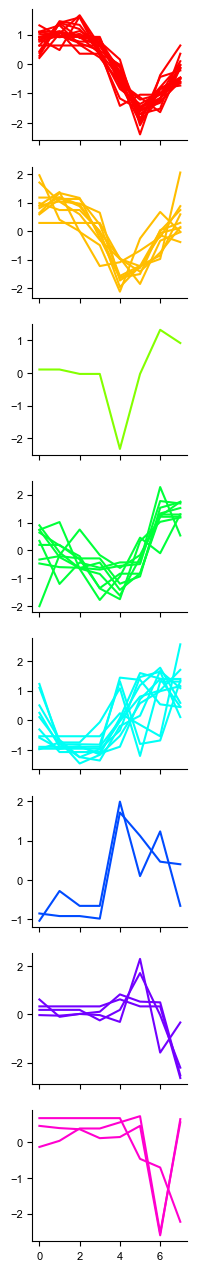

In [1010]:
ndelays_all = delays_all - delays_all.mean(axis=-1)[:,None]
ndelays_all = ndelays_all/ndelays_all.std(axis=-1)[:,None]

fig, axes = plt.subplots(figsize=(2, 16), nrows=8, sharex=True)
for i in range(8):
    axes[i].plot(ndelays_all[qdegs==i,:].T, color=plt.cm.hsv(i/8));

In [1036]:
data_cat = np.load('../../data/processed/data_cat_20250529.npz', allow_pickle=True)['data_cat']
vel_cat = np.load('../../data/processed/vel_cat_20250529.npz', allow_pickle=True)['vel_cat']
Ts = 1000

In [1038]:
val_cat = np.array(vel_cat)[:,:8]
data_cat = np.array(data_cat)[:, :8]

/opt/miniforge3/envs/cbmanifold/lib/python3.11/site-packages/sklearn/manifold/_mds.py:632: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


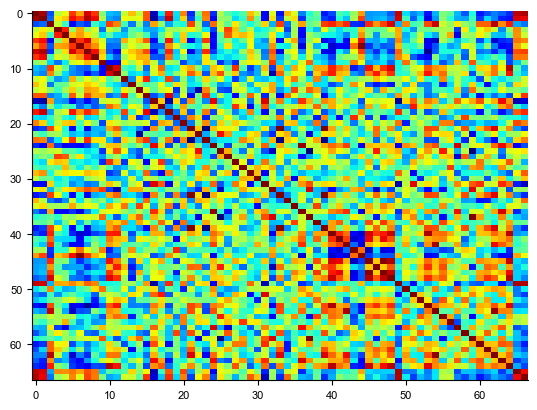

In [1039]:
import preprecessing_distMat

pdm = preprecessing_distMat.preprecessing_distMat(Ts, data_cat, vel_cat, '.')
onset_delay = pdm.peak_delay(win=20)
p_t = pdm.peak_MDS(onset_delay, True)

(np.float64(-3.930368064526874),
 np.float64(3.976401212126448),
 np.float64(-4.608530487613889),
 np.float64(5.543546924808361))

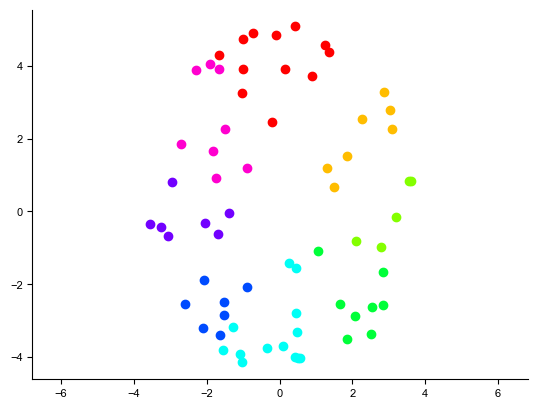

In [ ]:
#Sorting cell by degree

from scipy.spatial import distance
from math import degrees

sp1 = np.argsort(p_t[:,1])[::-1][:5]
sp2 = np.argsort(np.abs(p_t[sp1, :][:, 0]))
sp = sp1[sp2[0]]

# p = p_t[sp]
cent = np.mean(p_t, axis=0)
p = [cent[0], cent[1] + 6]

deg_f = []
for a in range(len(p_t)):
    q = p_t[a]
    cos = 1-distance.cosine(p, q)
    deg = degrees(np.arccos(cos))
    if q[0] - p[0] < 0:
        deg = 360 - deg

    deg_f.append(deg)
deg_f = np.array(deg_f)

deg_idx = np.linspace(0, 360, 9) + 22.5
deg_idx = np.append(deg_idx[7], deg_idx[:7])

C_cat = []
for a in range(len(deg_idx)):
    if a == 0:
        C = np.where(np.logical_or(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    elif a == 7:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[0]))
    else:
        C = np.where(np.logical_and(deg_f > deg_idx[a], deg_f <= deg_idx[a+1]))
    C_cat.append(C)


In [1061]:
cat_delta = np.zeros((p_t.shape[0]), dtype=int)
for a in range(8):
    cat_delta[C_cat[a]] = a
cat_delta

array([0, 0, 4, 7, 0, 0, 0, 0, 0, 1, 4, 5, 7, 1, 1, 0, 3, 4, 7, 2, 7, 4,
       6, 0, 3, 6, 6, 4, 1, 0, 1, 3, 1, 4, 7, 7, 3, 2, 6, 4, 4, 5, 4, 1,
       0, 5, 5, 5, 5, 7, 2, 2, 6, 4, 4, 6, 6, 3, 3, 2, 3, 5, 4, 3, 4, 7,
       0])

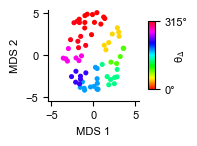

In [1087]:
# plotting
fig, ax = plt.subplots(figsize=(3, 1.5))

# plotting
sc = ax.scatter(p_t[:,0], p_t[:,1], 7, c=cat_delta, cmap='hsv')
ax.set_xlim(-5.4, 5.4)
ax.set_ylim(-5.4, 5.4)
ax.set_xlabel('MDS 1')
ax.set_ylabel('MDS 2')
ax.set_aspect('equal')

cbar = plt.colorbar(sc, ax=ax, fraction=0.046, aspect=10, pad=0.04, shrink=0.75)
cbar.set_label('θ$_\Delta$', labelpad=-10)
cbar.set_ticks([0, 7])
cbar.set_ticklabels(['0°', '315°'])


plt.tight_layout()

plt.savefig('MDS_cc.pdf', bbox_inches='tight')


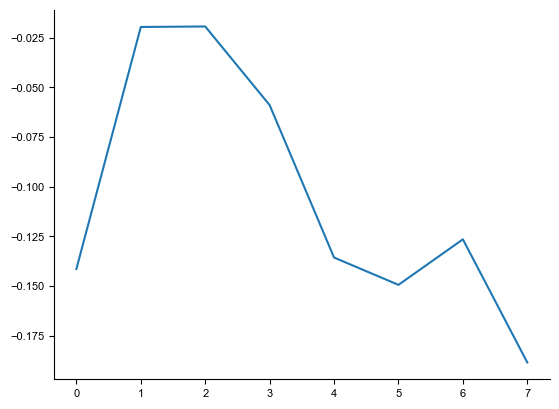

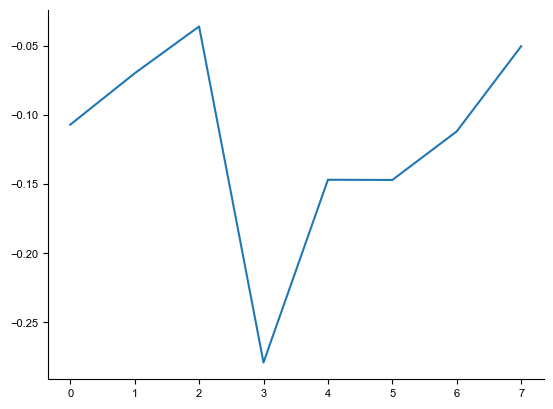

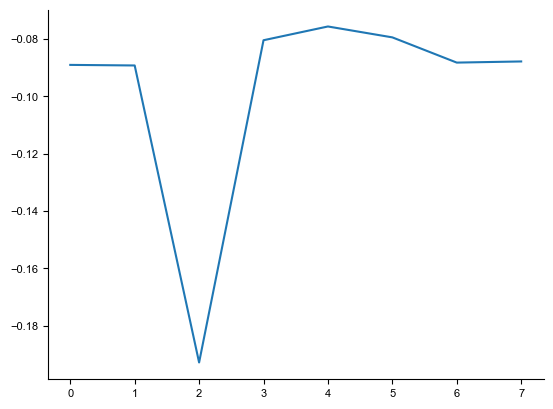

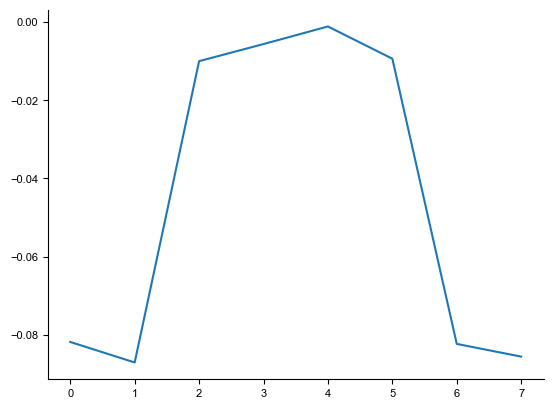

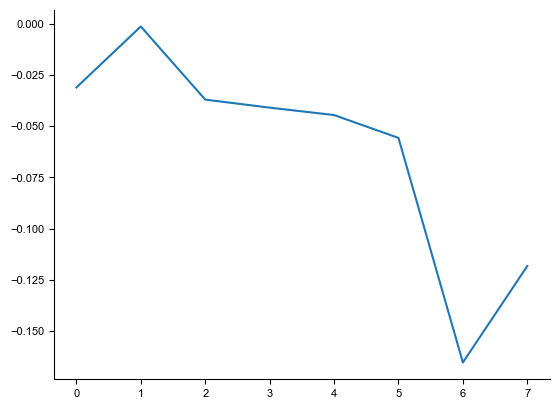

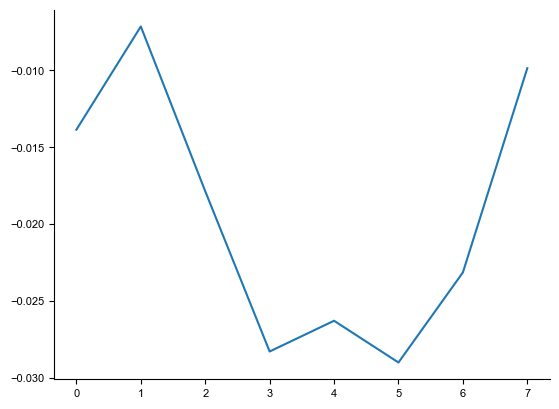

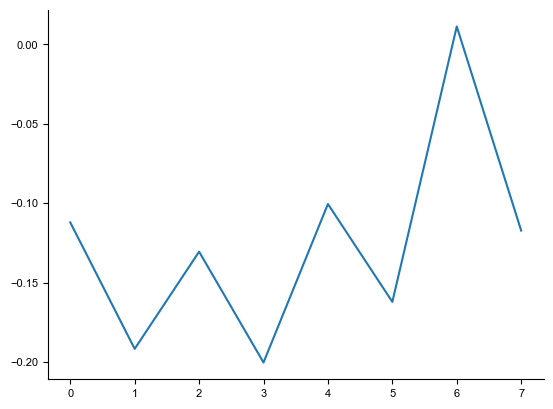

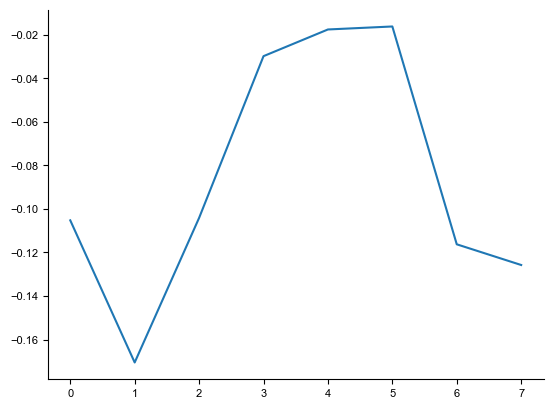

In [1089]:
# Aligned data by latency

onset_delay_M = onset_delay[C_cat[0]]
for a in range(1,8):
    temp = onset_delay[C_cat[a]]
    temp2 = np.concat([temp[:,a:8], temp[:,:a]], axis=1)
    onset_delay_M = np.vstack([onset_delay_M, temp2])

idx_c =[0]
for a in range(8):
    idx_c.append(len(C_cat[a][0]))
idx_c = np.cumsum(idx_c)

for a in range(8):
    plt.figure()
    plt.plot(np.mean(onset_delay_M[idx_c[a]:idx_c[a+1]], axis=0))

# Data align

data_cat2 = data_cat[C_cat[0]]
for a in range(1,8):
    temp = data_cat[C_cat[a]]
    temp2 = np.concat([temp[:,a:8], temp[:,:a]], axis=1)
    data_cat2 = np.vstack([data_cat2, temp2])

data_cat2 = np.hstack([data_cat2, data_cat2])  # put dummy for using analysis_pca code
data_cat2 = data_cat2[:,:9]

In [ ]:
np.savez('../../data/processed/data_cat2_20250529.npz', data_cat2, allow_pickle=True)

In [ ]:
#For FN angle aligned PCA

apca = analysis_pca.analysis_pca(Ts, data_cat2, save_path)
data_cat_sm = apca.smoothing_data()  # Smoothed data
data = np.mean(data_cat_sm, axis=0)  # Anagle averged data
PCA_total = apca.pca_analy(data)  # PCA

Wa = PCA_total['v'][:4]  # Wight matrix from angle averaged PCA

In [ ]:
#For FN angle original PCA

data_cat = np.hstack([data_cat, data_cat])  # put dummy for using analysis_pca code
data_cat = data_cat[:,:9]
apca = analysis_pca.analysis_pca(Ts, data_cat, save_path)
data_cat_sm2 = apca.smoothing_data()  # Smoothed data
data2 = np.mean(data_cat_sm2, axis=0)  # Anagle averged data
PCA_total2 = apca.pca_analy(data2)  # PCA

Wa2 = PCA_total2['v'][:4]  # Wight matrix from angle averaged PCA

In [ ]:
#Multiply weight matrix (MWM) to each angle data

final_out = []
for a in range(8):
    out = Wa @ data_cat_sm[a]
    final_out.append(out)

final_out = np.array(final_out)

In [ ]:
#Multiply weight matrix (MWM) to each angle data2 (original)

final_out2 = []
for a in range(8):
    out = Wa2 @ data_cat_sm2[a]
    final_out2.append(out)

final_out2 = np.array(final_out2)

In [ ]:
#Adjust MWM by subtract data point at -300 to -200ms

tmep_final = np.transpose(final_out,[2,0,1])
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :, :], 600, axis=0)
nfinal_out = np.transpose(tmep_final - sTemplet, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms

tmep_final = PCA_total['p']
sTemplet = np.mean(tmep_final[:100], axis=0)
sTemplet = np.repeat(sTemplet[np.newaxis, :], 600, axis=0)
nPCA_out = tmep_final.T - sTemplet.T

In [ ]:
#Adjust MWM by subtract data point at -300 to -200ms (original)

tmep_final2 = np.transpose(final_out2,[2,0,1])
sTemplet2 = np.mean(tmep_final2[:100], axis=0)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :, :], 600, axis=0)
nfinal_out2 = np.transpose(tmep_final2 - sTemplet2, [1, 2, 0])


#Adjust PCA by subtract data point at -300 to -200ms (original)

tmep_final2 = PCA_total2['p']
sTemplet2 = np.mean(tmep_final2[:100], axis=0)
sTemplet2 = np.repeat(sTemplet2[np.newaxis, :], 600, axis=0)
nPCA_out2 = tmep_final2.T - sTemplet2.T

In [ ]:
# Plotting raw data of each orientation
# label_ori = ['Up', 'Up right', 'Right', 'Down right',
#              'Down', 'Down left', 'Left', 'Up left']

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

c = 0
for a in range(8):
# for a in [2, 1, 0, 7, 6, 5, 4, 3]: # right to down right, anticlock-wise
    ax = axes[a // 4, a % 4]  # Determine the subplot location
    ax.imshow(data_cat_sm[a], aspect='auto', cmap='jet', origin='upper')  # Display the data
    ax.plot([300, 300], [0, len(data_cat_sm[0])], 'r', linewidth=1)  # Red vertical line
    ax.set_xticks(np.arange(0, 600, 100))  # Set X ticks
    ax.set_xticklabels(np.arange(-300, 300, 100))  # Set X tick labels
    # ax.set_title(label_ori[c])  # Set the title for each subplot
    ax.set_title([c])  # Set the title for each subplot
    ax.set_ylabel("Cell#")  # Set Y-axis label
    ax.set_xlabel("Time(ms)")  # Set X-axis label
    c = c + 1

plt.tight_layout()

plt.savefig('raw.jpg', dpi=300)
plt.show()

In [ ]:
# Plotting

plt.figure()
plt.plot(nPCA_out[0], nPCA_out[1])

plt.figure()
for a in range(8):
    plt.plot(nfinal_out[a][0], nfinal_out[a][1])

In [ ]:
fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out[a, 0]; Y = final_out[a, 1]; Z = final_out[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# 3D plot of adjusted data

# subfigs[1].subplots(1, 1, projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax = plt.figure().add_subplot(projection='3d')
for a in range(8):
    X = nfinal_out[a, 0]; Y = nfinal_out[a, 1]; Z = nfinal_out[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Adjusted")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# ax.view_init(elev=0, azim=-120)

In [ ]:
# Plotting (angle original)

plt.figure()
plt.plot(nPCA_out2[0], nPCA_out2[1])

plt.figure()
for a in range(8):
    plt.plot(nfinal_out2[a][0], nfinal_out2[a][1])

In [ ]:
# original

fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out2[a, 0]; Y = final_out2[a, 1]; Z = final_out2[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# 3D plot of adjusted data

# subfigs[1].subplots(1, 1, projection='3d')
ax = fig.add_subplot(1, 2, 2, projection='3d')
# ax = plt.figure().add_subplot(projection='3d')
for a in range(8):
    X = nfinal_out2[a, 0]; Y = nfinal_out2[a, 1]; Z = nfinal_out2[a, 2]
    ax.plot(X, Y, Z, label='parametric curve')
ax.set_title("Adjusted")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')

# ax.view_init(elev=0, azim=-120)

In [ ]:
X = final_out2[:, 0]; Y = final_out2[:, 1]; Z = final_out2[:, 2]

In [ ]:
np.hstack([X[:, 280], X[0, 280]])

In [ ]:
X

In [ ]:
# Pretty figure

from matplotlib.markers import CARETUP
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# color map
cmap = matplotlib.colormaps.get_cmap("gist_rainbow")
C_list = cmap( np.linspace(0.0, 1.0, 8) ) # extract 20 colors from cmap

fig = plt.figure(constrained_layout=True,figsize=(12,5))
# subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1, 1])

# 3D plot of angle original data

# subfigs[0].subplots(1, 1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
for a in range(8):
    X = final_out2[a, 0]; Y = final_out2[a, 1]; Z = final_out2[a, 2]
    ax.plot(X[200:500], Y[200:500], Z[200:500], label='parametric curve', color = C_list[a], linewidth = 0.5)

    ax.scatter(X[280], Y[280], Z[280], s=60, color = C_list[a], facecolors=C_list[a], edgecolors='black')
    ax.scatter(X[300], Y[300], Z[300], marker='^', s=60, color = C_list[a], facecolors = C_list[a], edgecolors='black')
# X = final_out2[:, 0]; Y = final_out2[:, 1]; Z = final_out2[:, 2]
# ax.plot(np.hstack([X[:, 280], X[0, 280]]),
#         np.hstack([Y[:, 280], Y[0, 280]]),
#         np.hstack([Z[:, 280], Z[0, 280]]),
#         ls = '-', color = 'k')
# ax.plot(np.hstack([X[:, 300], X[0, 300]]),
#         np.hstack([Y[:, 300], Y[0, 300]]),
#         np.hstack([Z[:, 300], Z[0, 300]]),
#         ls = '-', color = 'k')


ax.set_title("Original")
ax.set_xlabel('1D'); ax.set_ylabel('2D'); ax.set_zlabel('3D')


# 3D plot of angle aligned data

# subfigs[0].subplots(1, 1)
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for a in range(8):
    X = final_out[a, 0]; Y = final_out[a, 1]; Z = final_out[a, 2]
    ax2.plot(X[200:500], Y[200:500], Z[200:500], label='parametric curve', color = C_list[a], linewidth = 0.5)
    ax2.scatter(X[280], Y[280], Z[280], s=60, color = C_list[a], facecolors=C_list[a], edgecolors='black')
    ax2.scatter(X[300], Y[300], Z[300], marker='^', s=60, color = C_list[a], facecolors = C_list[a], edgecolors='black')
# X = final_out[:, 0]; Y = final_out[:, 1]; Z = final_out[:, 2]
# ax2.plot(np.hstack([X[:, 280], X[0, 280]]),
#         np.hstack([Y[:, 280], Y[0, 280]]),
#         np.hstack([Z[:, 280], Z[0, 280]]),
#         ls = '-', color = 'k')
# ax2.plot(np.hstack([X[:, 300], X[0, 300]]),
#         np.hstack([Y[:, 300], Y[0, 300]]),
#         np.hstack([Z[:, 300], Z[0, 300]]),
#         ls = '-', color = 'k')


ax2.set_title("Aligned")
ax2.set_xlabel('1D'); ax2.set_ylabel('2D'); ax2.set_zlabel('3D')

# animation
def run(frame_number):
    ax.view_init(azim=225 + frame_number*2)
    ax2.view_init(azim=225 + frame_number*2)

anim = FuncAnimation(fig, run, frames=180, interval=20)

HTML(anim.to_jshtml())
# plt.show()

# anim.save('scatter.gif', writer='imagemagick', fps=25, dpi=80)

In [ ]:
# Fitting

pca_p = nPCA_out[:4]
time = np.linspace(-300, 300, 600)

r_s_total = []
for a in range(8):
    resid = np.linalg.norm(pca_p - nfinal_out[a], axis=1)**2
    r_s = 1 - resid / (final_out[a].size * nfinal_out[a].var())
    r_s_total.append(r_s)

r_s_total = np.array(r_s_total)

In [ ]:
# Plotting

a = 1
b = 0

r_s = r_s_total[a][b]
plt.plot(time, pca_p[b], time, nfinal_out[a][b], 'r')
plt.title(f'direction={a}, pc={b}, R^2={r_s}')

In [ ]:
# a=24
# t = np.arange(-250,250)
# plt.plot(t, pFN[a], t, pMPC @ betas[a], 'r')
# resid = np.linalg.norm(pMPC @ betas[a] - pFN[a])**2
# r_s = 1 - resid / (pFN[a].size * pFN[a].var())`a
# plt.title(f'a={a}, R^2={r_s}')